In [9]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [10]:
n = 1024  # object size in x,y
nz = 1024  # object size in z    
ntheta = 1  # number of angles (rotations)

pnz = nz # tomography chunk size for GPU processing 
ptheta = ntheta # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
focusToDetectorDistance = 1.28 # [m]
ncodes = 4
sx0 = 3.7e-4 # [m] motor offset from the focal spot
z1 = np.array([4.584,4.765,5.488,6.9895])*1e-3-sx0 # distances between planes and the focal spot
# z1 = np.tile(np.array([4.584e-3]),ncodes)-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes


## Read data

In [11]:
data = np.zeros([len(distances),ntheta,nz,n],dtype='float32')
prb = np.zeros([len(distances),nz,n],dtype='complex64')
for k in range(len(distances)):
    data[k] = dxchange.read_tiff(f'data/modeling/data_{n}_{k}.tiff')[:ntheta]
for k in range(len(distances)):
    prb[k] = dxchange.read_tiff(f'data/modeling/prb_amp_{n}_{k}.tiff')[:]*np.exp(1j*dxchange.read_tiff(f'data/modeling/prb_angle_{n}_{k}.tiff')[:])


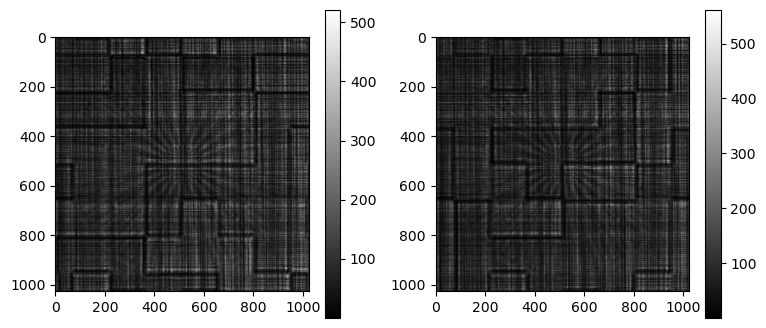

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(data[0,0],cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(data[-1,0],cmap='gray')
fig.colorbar(im)


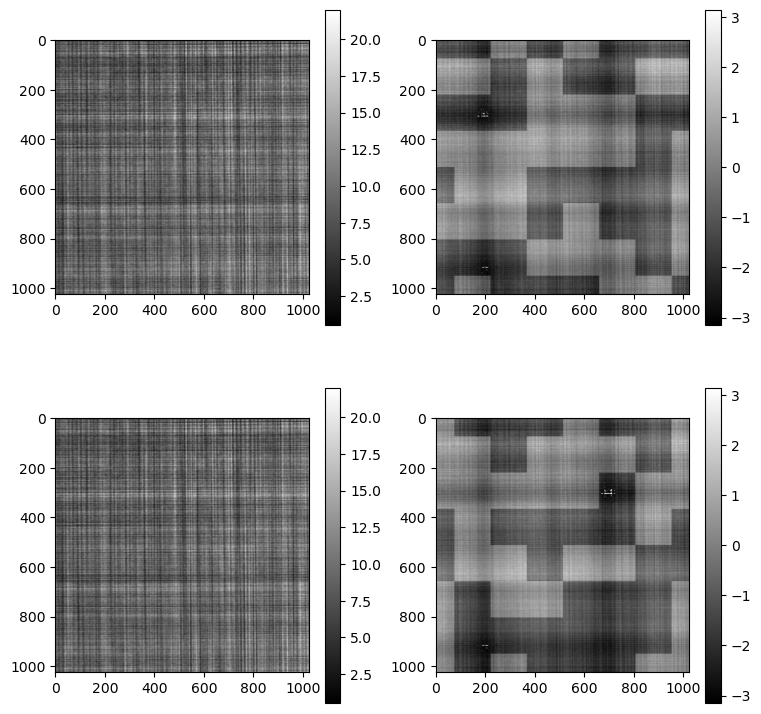

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(prb[0]),cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(prb[-1]),cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(prb[-1]),cmap='gray')
fig.colorbar(im)

## Create a solver class for holography

In [14]:
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

# Solving the problem $\sum_{k,j}\||\mathcal{G}_kq_k \psi_j|-d_{k,j}\|_2\to min$ with the Conjugate Gradient

In [15]:
import cupy as cp

def line_search(minf, gamma, u, fu, d, fd):
    """ Line search for the step sizes gamma"""
    while(minf(u, fu)-minf(u+gamma*d, fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
    
def cg_holo(data, init, prb,  piter):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    
    maxprb = cp.max(cp.abs(prb))
    gamma = 1# init gamma as a large value
    for i in range(piter):
        fpsi = pslv.fwd_holo(psi,prb)
        grad = pslv.adj_holo(
           fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb)/maxprb**2
        #grad = pslv.adj_holo(
             #(cp.abs(fpsi)**2-data)*fpsi,prb)/maxprb**2
        
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = -grad+cp.linalg.norm(grad)**2 / \
                ((cp.sum(cp.conj(d)*(grad-grad0))))*d
        grad0 = grad
        # line search
        fd = pslv.fwd_holo(d, prb)
        gamma = line_search(minf, gamma, psi, fpsi, d, fd)
        psi = psi + gamma*d
        print(f'{i}) {gamma=}, err={minf(psi,fpsi)}')
    
    return psi

def cg_holo_batch(data, init, prb, piter):
    """Batch of CG solvers"""
    
    res = np.zeros([ntheta, nz, n], dtype='complex64')
    prb_gpu = cp.array(prb)            
    for ids in holotomo.utils.chunk(range(ntheta), ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        init_gpu = cp.array(init[ids])
        # Radon transform
        res_gpu = cg_holo(data_gpu, init_gpu,prb_gpu, piter)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res



piter = 128 # number of CG iters
init = np.ones([ntheta,nz,n],dtype='complex64')  # initial guess
rec = cg_holo_batch(data, init, prb,  piter)

0) gamma=1, err=1385376.125
1) gamma=1, err=247973.671875
2) gamma=1, err=95264.9921875
3) gamma=1, err=54869.08203125
4) gamma=1, err=37870.4765625
5) gamma=1, err=28132.52734375
6) gamma=1, err=21761.3671875
7) gamma=1, err=17515.638671875
8) gamma=1, err=14659.9072265625
9) gamma=1, err=12693.8232421875
10) gamma=1, err=11236.369140625
11) gamma=1, err=10106.5703125
12) gamma=1, err=9195.724609375
13) gamma=1, err=8459.720703125
14) gamma=1, err=7855.771484375
15) gamma=1, err=7366.1171875
16) gamma=1, err=7003.7890625
17) gamma=1, err=6633.09912109375
18) gamma=1, err=6396.458984375
19) gamma=1, err=6177.19970703125
20) gamma=1, err=5990.54638671875
21) gamma=1, err=5844.6953125
22) gamma=1, err=5728.42333984375
23) gamma=1, err=5623.0869140625
24) gamma=1, err=5512.66259765625
25) gamma=1, err=5427.603515625
26) gamma=1, err=5347.6181640625
27) gamma=1, err=5260.02099609375
28) gamma=1, err=5185.20849609375
29) gamma=1, err=5117.4443359375
30) gamma=1, err=5045.3583984375
31) gamm

Image similarity 0.21346189679366265


Text(0.5, 1.0, 'phase error, ssim 0.213')

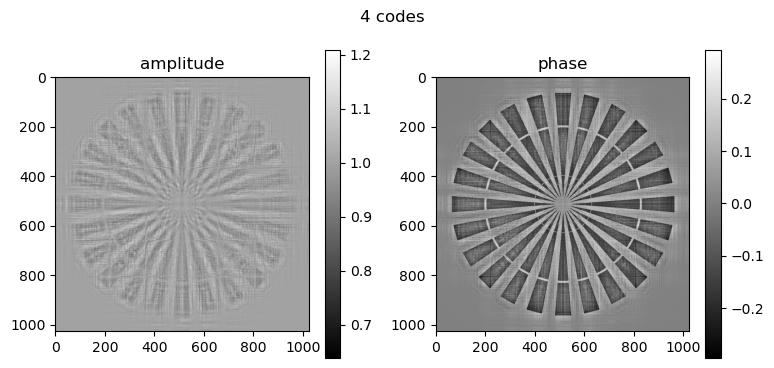

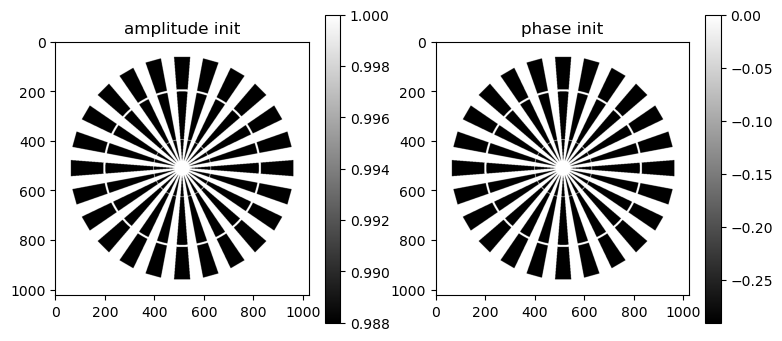

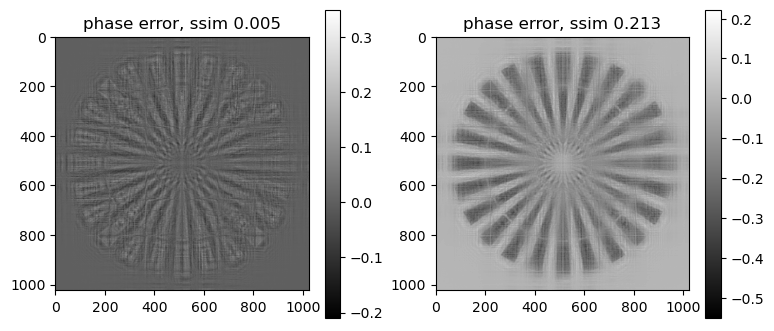

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle(f'{ncodes} codes')
im=axs[0].imshow(np.abs(rec[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)
psi0 = dxchange.read_tiff(f'data/modeling/psi_amp_{n}.tiff')[:]*np.exp(1j*dxchange.read_tiff(f'data/modeling/psi_angle_{n}.tiff')[:])
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi0),cmap='gray')
axs[0].set_title('amplitude init')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi0),cmap='gray')
axs[1].set_title('phase init')
fig.colorbar(im)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi0)-np.abs(rec[0]),cmap='gray')
axs[0].set_title('amplitude error')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi0)-np.angle(rec[0]),cmap='gray')
axs[1].set_title('phase error')
fig.colorbar(im)
from skimage.metrics import structural_similarity
a = np.abs(rec[0])
b = np.abs(psi0)
a-=np.mean(a)
b-=np.mean(b)
data_range=np.amax(b)-np.amin(b)
(score, diff) = structural_similarity(a,b, full=True,data_range=data_range)
axs[0].set_title(f'phase error, ssim {score:.3f}')
a = np.angle(rec[0])
b = np.angle(psi0)
a-=np.mean(a)
b-=np.mean(b)
data_range=np.amax(b)-np.amin(b)
(score, diff) = structural_similarity(a,b, full=True,data_range=data_range)
print("Image similarity", score)
axs[1].set_title(f'phase error, ssim {score:.3f}')
